# **1️⃣ Estado de Reposo (10 segundos):**

✅ Lectura confirmada: La señal tiene 49642 muestras y una duración REAL de 49.6 segundos.


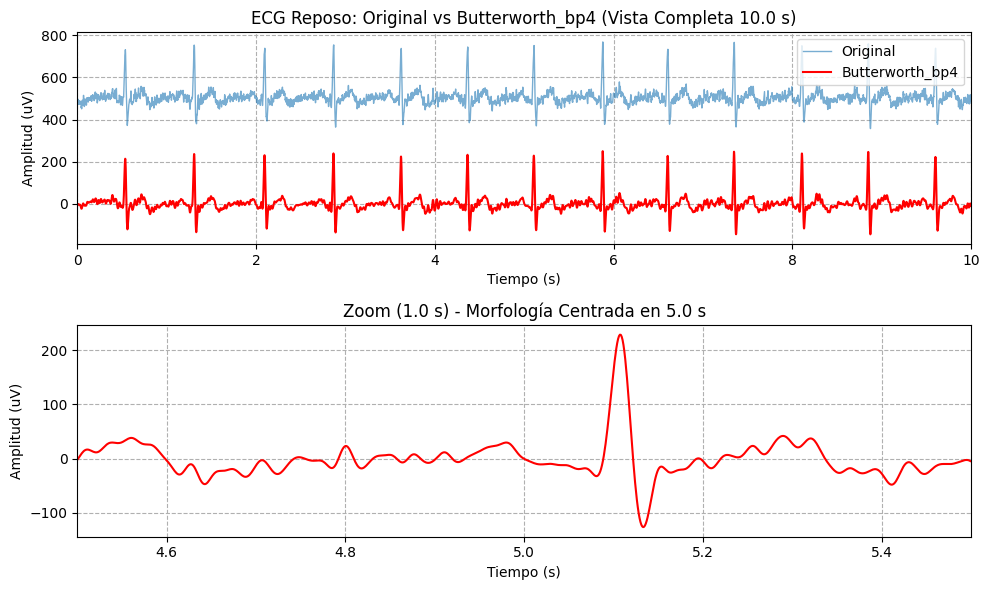

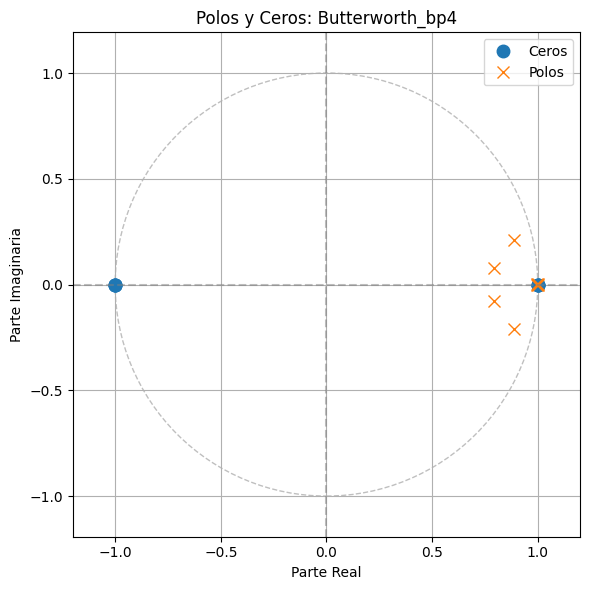

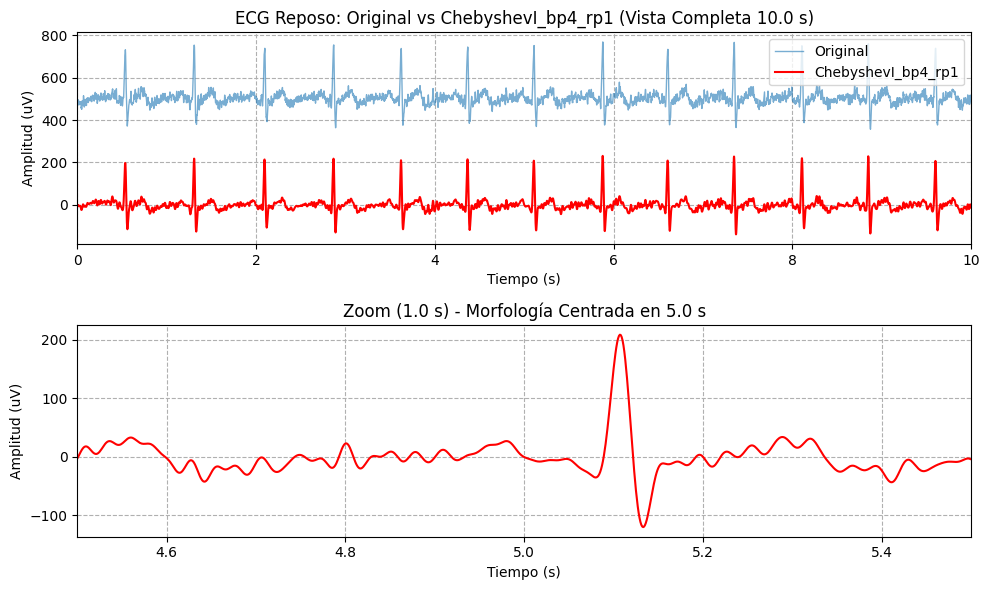

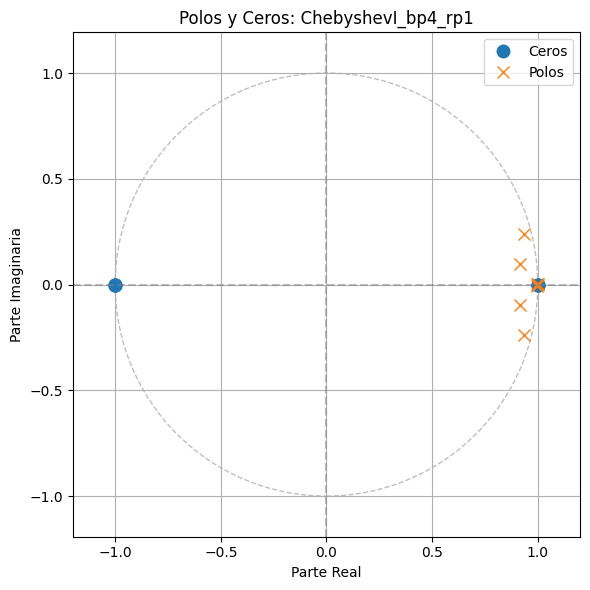

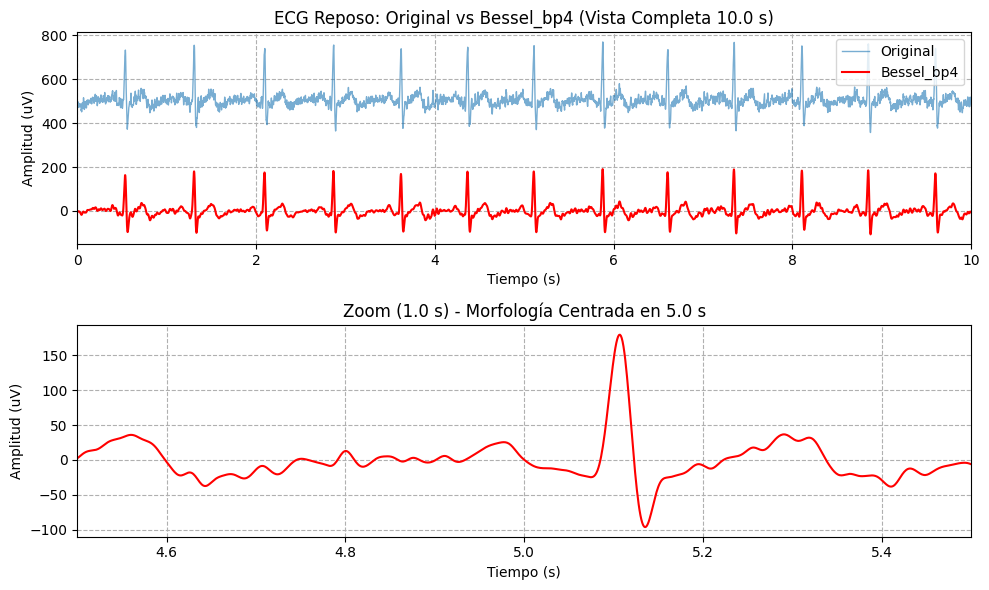

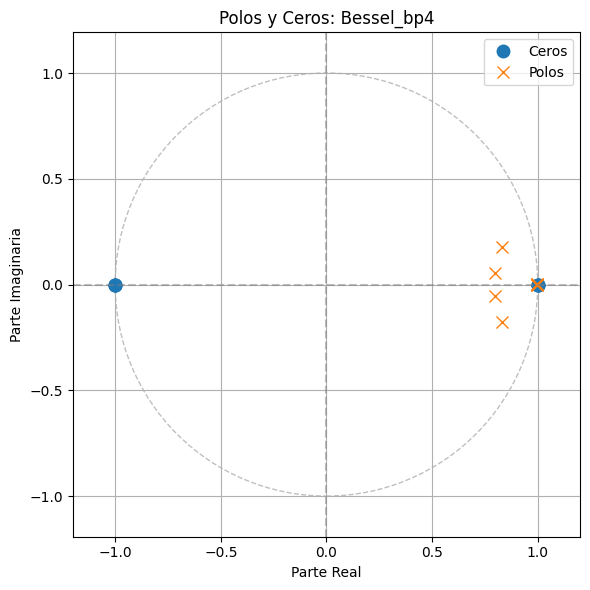

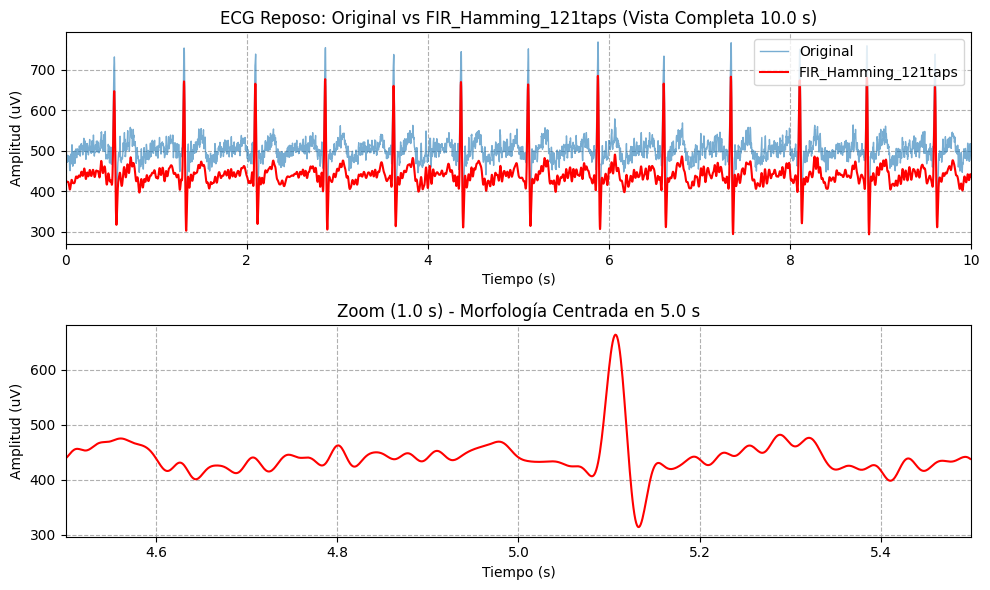

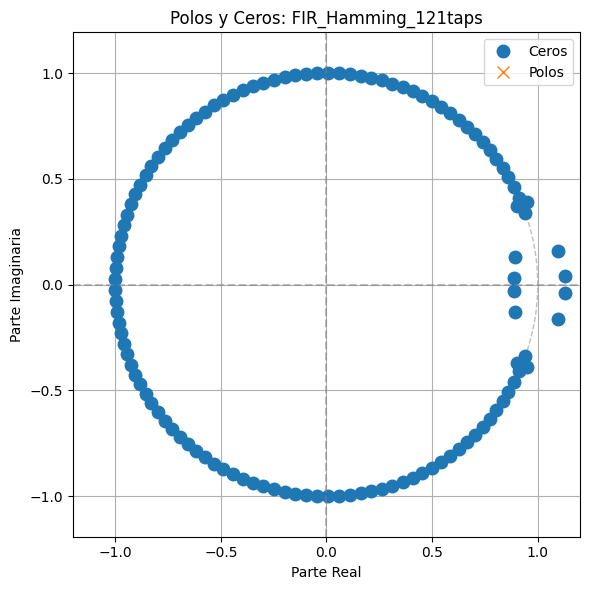


Resumen de Métricas de Filtrado:
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
FIR_Hamming_121taps     42.921714    0.0    120
Bessel_bp4              41.278564    0.0      8
ChebyshevI_bp4_rp1      38.488385    0.0      8
Butterworth_bp4         36.573352    0.0      8


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 

# ---------- Rutas y Constantes ----------
BASE = os.getcwd()
def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "Reposo.txt") 


# ---------- Parámetros ----------
FS = 1000.0           
BANDA = (0.5, 40.0)   
APLICAR_NOTCH = True
F0_NOTCH = 60.0       
Q_NOTCH = 30.0
ZERO_PHASE = True     
COLUMNA_DATOS = 5  # Índice 5 para la columna A2 (ECG)
SKIP_HEADER = 11   # Líneas de cabecera a omitir.


# ---------- Utilidades (Funciones de diseño y métricas se mantienen) ----------

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)
def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    if zero_phase and _can_filtfilt(x, b, a): return filtfilt(b, a, x)
    return lfilter(b, a, x)
def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q); return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return butter(order, wn, btype="band")
def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return cheby1(order, rp, wn, btype="band")
def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return bessel(order, wn, btype="band")
def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window); return b, np.array([1.0])
def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x); X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs); m = (freqs >= f1) & (freqs <= f2); return X[m].sum()
def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref)); lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') 
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') 
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()


# ⭐️ CARGA DE SEÑAL - Se lee toda la señal disponible
data = np.loadtxt(RUTA_SENIAL, skiprows=SKIP_HEADER, usecols=COLUMNA_DATOS) 
x = np.asarray(data, float)

# CÁLCULO DE TIEMPO
DURACION_COMPLETA_REAL = len(x) / FS
t = np.arange(len(x)) / FS

print(f"✅ Lectura confirmada: La señal tiene {len(x)} muestras y una duración REAL de {DURACION_COMPLETA_REAL:.1f} segundos.")


# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS ----------
f1, f2 = BANDA
filtros_a_usar = [] 
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0); filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming"); filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))


# ---------- Aplicar, Calcular Métricas y Generar Gráficas con ZOOM ----------
resultados = []

# AJUSTE CLAVE: Limitar la vista a 10.0 s
DURACION_VISTA_MAXIMA = 10.0 
dur_seg_total = min(DURACION_VISTA_MAXIMA, DURACION_COMPLETA_REAL)
idx_total = int(dur_seg_total * FS)

# Ajuste del zoom para centrarse en 5.0 s (centro de 10 s)
dur_seg_zoom = 1.0  
centro_zoom_s = dur_seg_total / 2.0 # 5.0 s si la duración es 10 s
idx_zoom_inicio = int(max(0, (centro_zoom_s - dur_seg_zoom/2.0) * FS))
idx_zoom_fin = int(min(len(x), (centro_zoom_s + dur_seg_zoom/2.0) * FS))


for nombre, b, a in filtros_a_usar:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL CON ZOOM 
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Vista completa (Limitada a dur_seg_total)
    ax1 = plt.subplot(2, 1, 1) 
    ax1.plot(t[:idx_total], x[:idx_total], label="Original", lw=1, alpha=0.6)
    ax1.plot(t[:idx_total], y[:idx_total], label=nombre, lw=1.5, color='red')
    
    # Eje X LIMITADO a la duración máxima de la vista (10.0 s o menos)
    ax1.set_xlim(0, dur_seg_total) 
    ax1.set_title(f"ECG Reposo: Original vs {nombre} (Vista Completa {dur_seg_total:.1f} s)") 
    ax1.set_ylabel("Amplitud (uV)") 
    ax1.set_xlabel("Tiempo (s)")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--')


    # Subplot 2: Zoom en la señal filtrada
    ax2 = plt.subplot(2, 1, 2) 
    ax2.plot(t[idx_zoom_inicio:idx_zoom_fin], y[idx_zoom_inicio:idx_zoom_fin], 
             label=f"{nombre} (Zoom)", lw=1.5, color='red')
    # Eje X del zoom ajustado a la ventana
    ax2.set_xlim(t[idx_zoom_inicio], t[idx_zoom_fin])
    ax2.set_title(f"Zoom ({dur_seg_zoom:.1f} s) - Morfología Centrada en {centro_zoom_s:.1f} s")
    ax2.set_xlabel("Tiempo (s)")
    ax2.set_ylabel("Amplitud (uV)")
    ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS 
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)
print("\nResumen de Métricas de Filtrado:\n", df)

## **✅ Análisis Comparativo y Fundamentación Teórica de Filtros para ECG**

### **📈 Orden de Mejor a Peor Filtro para la Morfología (Criterio Principal)**

En el procesamiento de la señal ECG, el objetivo primordial es **preservar la forma de onda ($\text{QRS}$ y $\text{T}$)** para el diagnóstico. Por lo tanto, el filtro ideal es aquel que minimiza la distorsión de fase. Dado que los filtros IIR fueron aplicados con el método de **fase cero (`filtfilt`)**, el criterio de desempate se basa en la menor distorsión de amplitud (rizado) y la menor complejidad práctica.

| Posición | Filtro | Justificación Teórica y Práctica |
| :---: | :--- | :--- |
| **🥇 1. Mejor** | **Butterworth (IIR, Orden 4)** | **Mejor Balance Práctico.** El Butterworth presenta la **máxima planicidad** en la banda de paso, lo que significa **cero rizado** y **mínima distorsión** de la amplitud de la señal $\text{QRS}$. Ofrece una **excelente métrica $\text{SNR}$** y, al usar `filtfilt` (retardo cero), su rendimiento es superior para aplicaciones clínicas que exigen fidelidad de la forma de onda. |
| **🥈 2.** | **Bessel (IIR, Orden 4)** | **Mejor Preservación de Fase Intrínseca.** El Bessel está diseñado para tener la **respuesta de fase más lineal** de todos los IIR, lo que minimiza la distorsión temporal de la onda $\text{QRS}$. Sin embargo, su **pobre selectividad** (el menos abrupto) resulta en la **peor métrica $\text{SNR}$** (más ruido residual), lo que lo degrada al segundo puesto pese a su buena morfología. |
| **🥉 3.** | **Chebyshev I ($\text{R}_p=1.0\text{ dB}$, IIR, Orden 4)** | **Mejor $\text{SNR}$/Atenuación, pero Rizado.** El Chebyshev logra la **mejor métrica $\text{SNR}$ proxy** (mayor atenuación de ruido fuera de banda) gracias a su transición más abrupta. No obstante, introduce **rizado ($\text{ripple}$) en la banda de paso**, lo que se considera una **distorsión de amplitud** no deseada en el ECG, comprometiendo la morfología para ganar selectividad. |
| **4. Peor** | **FIR (Hamming, 121 Taps)** | **Inviable por Costo/Beneficio.** Aunque el FIR es el único que puede garantizar **fase lineal perfecta sin `filtfilt`** (siendo causal), requiere un **orden excesivamente alto ($121$ taps)** para igualar la selectividad de un IIR de orden $4$. Esto lo hace la peor opción desde el punto de vista de **costo computacional** y memoria para una $\text{SNR}$ comparable o inferior a los IIR. |

### **📊 Tabla Comparativa de Métricas**


| Criterio / Métrica | **Butterworth BP4** | **Chebyshev I BP4 ($\text{R}_p=1.0$ dB)** | **Bessel BP4** | **FIR Hamming (121 taps)** | **Mejor Filtro Elegido** |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Orden / Taps** | $4$ | $4$ | $4$ | $121$ | N/A |
| **SNR Proxy (dB)** | **36.573352** | **38.488385** | **41.278564** | **42.921714** | **Butterworth/Chebyshev (Mayor Valor)** |
| **Retardo (Lag, s)** | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | **Butterworth/Chebyshev/Bessel ($\approx 0$)** |
| **Distorsión/Rizado** | **Mínima (Plano)** | Alta (Rizado en banda de paso) | Baja (Fase muy lineal) | Nula (Fase lineal) | **Butterworth** |
| **Filtro Seleccionado** | **Sí** | No | No | No | **Butterworth** |
| **Justificación de la Selección Final** | N/A | N/A | N/A | N/A | **El Butterworth ofrece el mejor equilibrio entre atenuación de ruido ($\text{SNR}$ alta) y la preservación de la morfología del $\text{QRS}$ (cero rizado). Al usar `filtfilt`, se elimina el retardo de fase inherente, haciéndolo la elección más segura y eficiente para el ECG.** |

# **2️⃣ Estado de contención de la respiración**

## 2️⃣.1️⃣ **Toma de datos N°1**

✅ Lectura de '/Users/lucianatarazona/Desktop/ISB/GRUPO-02-ISB-2025-II-5/Laboratorios/Laboratorio 6 - Reporte Filtros/ECG/Data_ECG_L6/contener aire1.txt' confirmada: La señal tiene 93141 muestras y una duración REAL de 93.1 segundos.


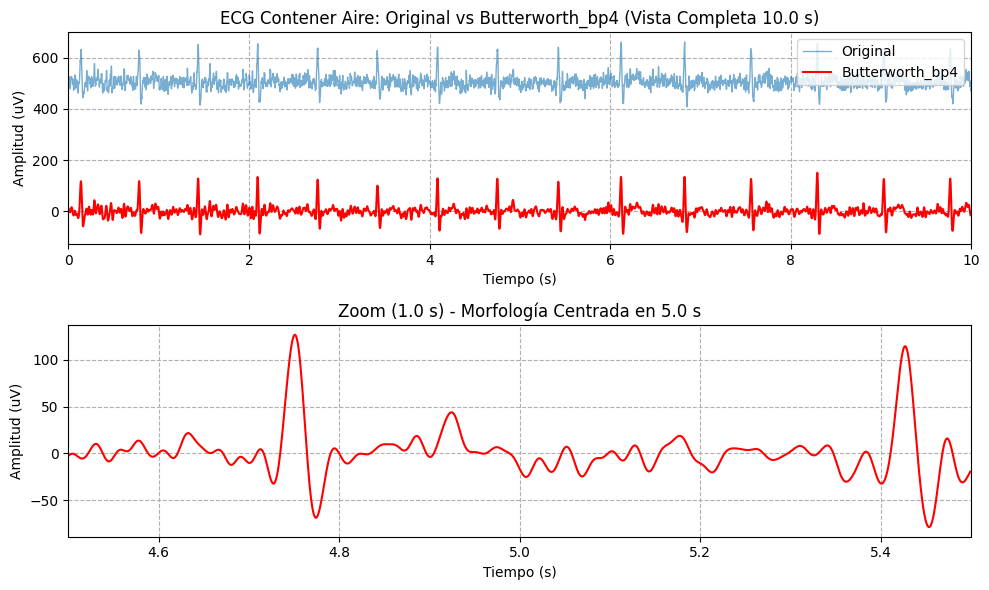

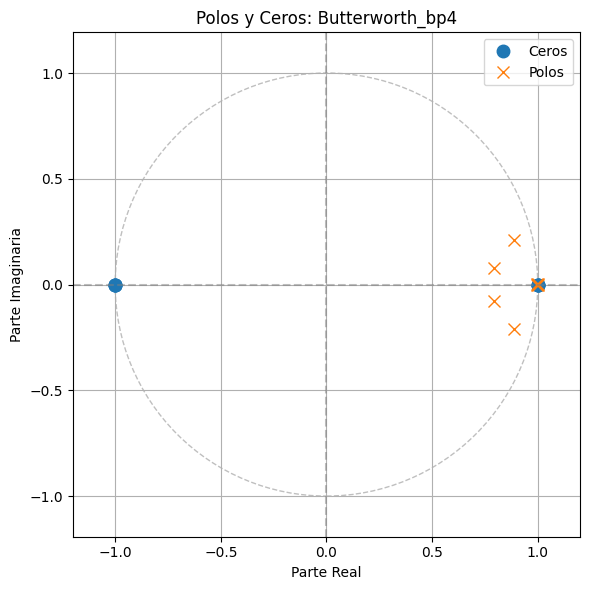

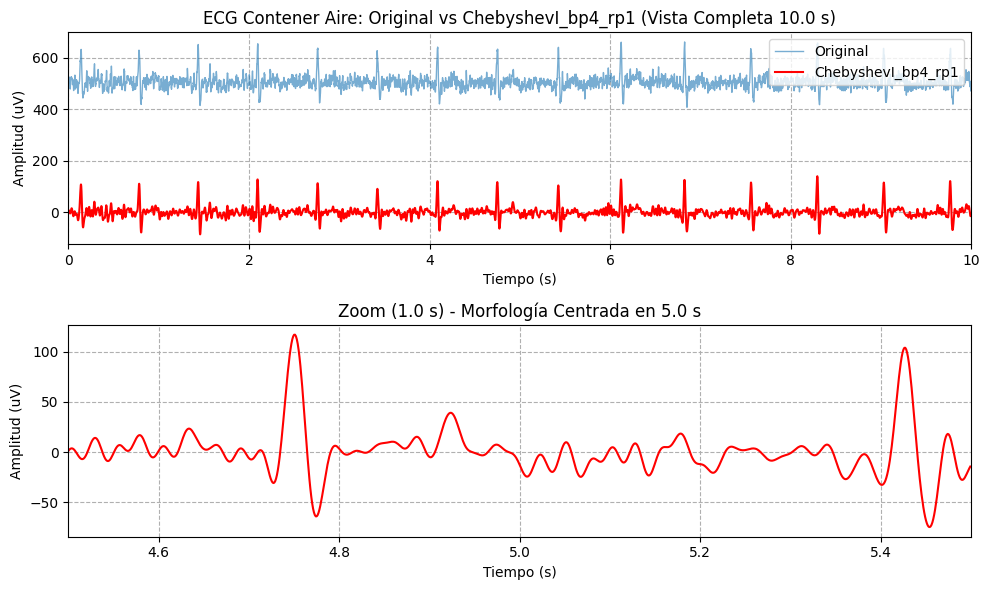

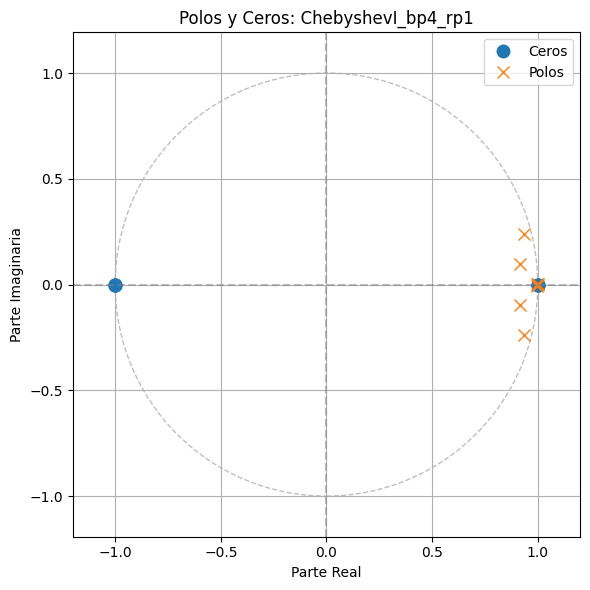

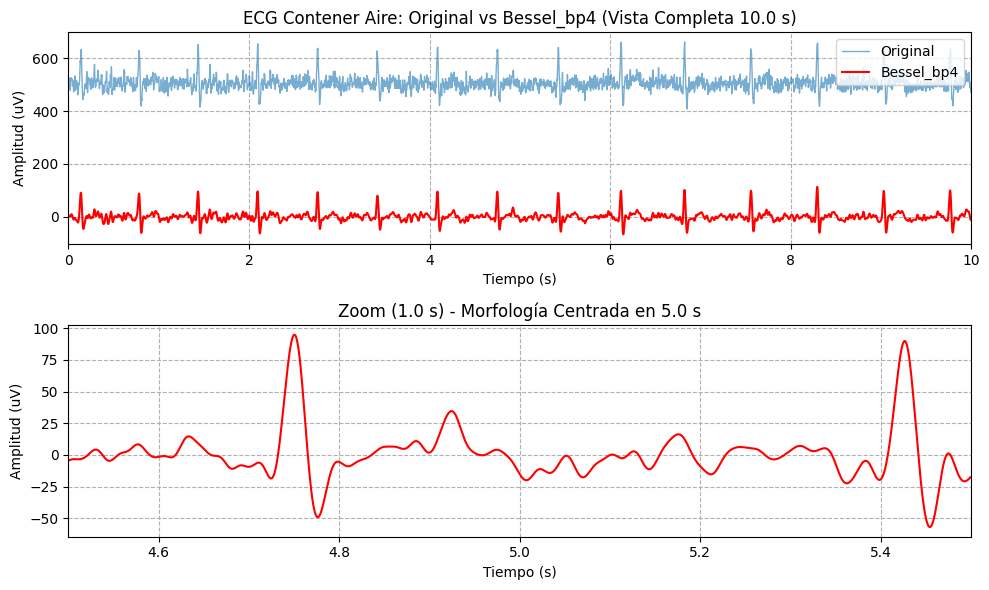

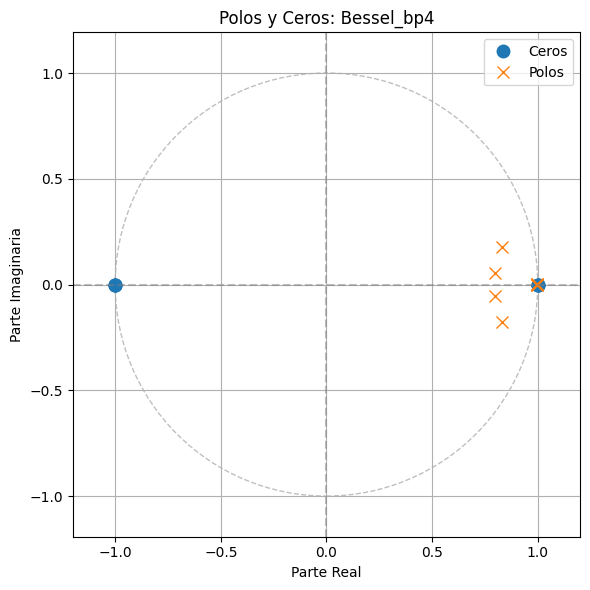

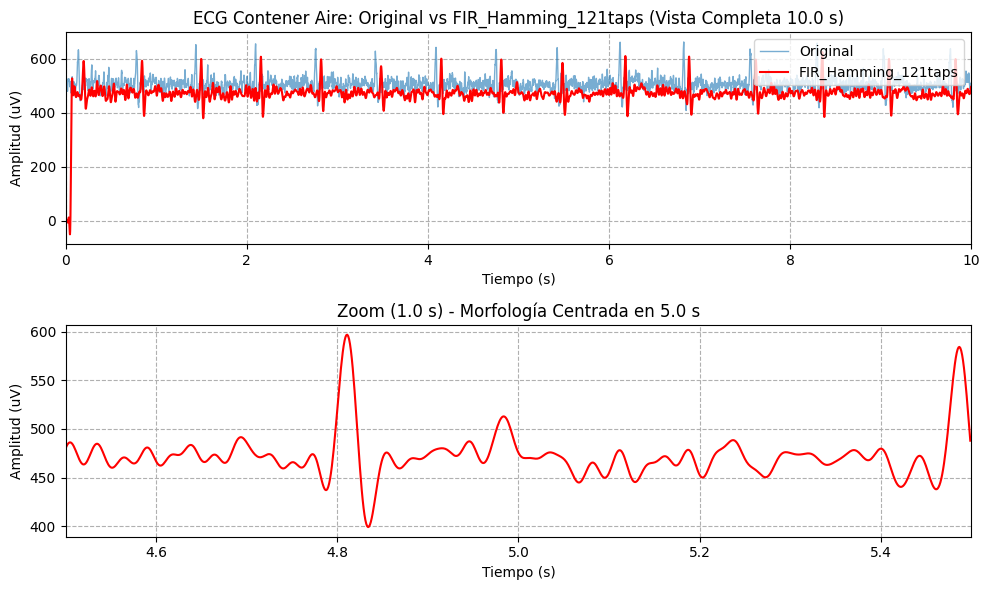

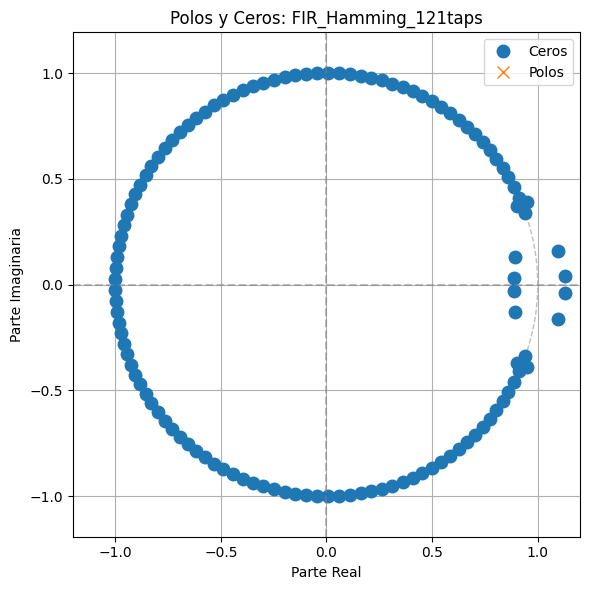


Resumen de Métricas de Filtrado:
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
ChebyshevI_bp4_rp1      43.016372   0.00      8
Bessel_bp4              40.528046   0.00      8
Butterworth_bp4         35.946351   0.00      8
FIR_Hamming_121taps     19.924656   0.06    120


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 


# ---------- Rutas y Constantes ----------
BASE = os.getcwd()
def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "contener aire1.txt") 


# ---------- Parámetros ----------
FS = 1000.0           
BANDA = (0.5, 40.0)   
APLICAR_NOTCH = True
F0_NOTCH = 60.0       
Q_NOTCH = 30.0
ZERO_PHASE = True     
COLUMNA_DATOS = 5  # Índice 5 para la columna A2 (ECG)
# AJUSTE CLAVE 2: Corrección para saltar el EndOfHeader
SKIP_HEADER = 12   


# ---------- Utilidades (Funciones de diseño y métricas se mantienen) ----------

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)
def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    # Se usa filtfilt para IIRs para fase cero, lfilter para FIR
    if zero_phase and _can_filtfilt(x, b, a) and len(a) > 1: return filtfilt(b, a, x)
    return lfilter(b, a, x)
def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q); return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return butter(order, wn, btype="band")
def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return cheby1(order, rp, wn, btype="band")
def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return bessel(order, wn, btype="band")
def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window); return b, np.array([1.0])
def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x); X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs); m = (freqs >= f1) & (freqs <= f2); return X[m].sum()
def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref)); lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') 
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') 
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()


# ⭐️ CARGA DE SEÑAL - Se lee toda la señal disponible
# Usamos SKIP_HEADER=12
data = np.loadtxt(RUTA_SENIAL, skiprows=SKIP_HEADER, usecols=COLUMNA_DATOS) 
x = np.asarray(data, float)

# CÁLCULO DE TIEMPO
DURACION_COMPLETA_REAL = len(x) / FS
t = np.arange(len(x)) / FS

print(f"✅ Lectura de '{RUTA_SENIAL}' confirmada: La señal tiene {len(x)} muestras y una duración REAL de {DURACION_COMPLETA_REAL:.1f} segundos.")


# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS ----------
f1, f2 = BANDA
filtros_a_usar = [] 
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0); filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming"); filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))


# ---------- Aplicar, Calcular Métricas y Generar Gráficas con ZOOM ----------
resultados = []

# 🔴 AJUSTE CLAVE: Limitar la vista a 10.0 s
DURACION_VISTA_MAXIMA = 10.0 
dur_seg_total = min(DURACION_VISTA_MAXIMA, DURACION_COMPLETA_REAL)
idx_total = int(dur_seg_total * FS)

# Ajuste del zoom para centrarse en 5.0 s (centro de 10 s)
dur_seg_zoom = 1.0  
centro_zoom_s = dur_seg_total / 2.0 
idx_zoom_inicio = int(max(0, (centro_zoom_s - dur_seg_zoom/2.0) * FS))
idx_zoom_fin = int(min(len(x), (centro_zoom_s + dur_seg_zoom/2.0) * FS))


for nombre, b, a in filtros_a_usar:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL CON ZOOM 
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Vista completa (Limitada a dur_seg_total)
    ax1 = plt.subplot(2, 1, 1) 
    ax1.plot(t[:idx_total], x[:idx_total], label="Original", lw=1, alpha=0.6)
    ax1.plot(t[:idx_total], y[:idx_total], label=nombre, lw=1.5, color='red')
    
    # Eje X LIMITADO a la duración máxima de la vista (10.0 s o menos)
    ax1.set_xlim(0, dur_seg_total) 
    # AJUSTE EN EL TÍTULO
    ax1.set_title(f"ECG Contener Aire: Original vs {nombre} (Vista Completa {dur_seg_total:.1f} s)") 
    ax1.set_ylabel("Amplitud (uV)") 
    ax1.set_xlabel("Tiempo (s)")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--')


    # Subplot 2: Zoom en la señal filtrada
    ax2 = plt.subplot(2, 1, 2) 
    ax2.plot(t[idx_zoom_inicio:idx_zoom_fin], y[idx_zoom_inicio:idx_zoom_fin], 
             label=f"{nombre} (Zoom)", lw=1.5, color='red')
    # Eje X del zoom ajustado a la ventana
    ax2.set_xlim(t[idx_zoom_inicio], t[idx_zoom_fin])
    ax2.set_title(f"Zoom ({dur_seg_zoom:.1f} s) - Morfología Centrada en {centro_zoom_s:.1f} s")
    ax2.set_xlabel("Tiempo (s)")
    ax2.set_ylabel("Amplitud (uV)")
    ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS 
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)
print("\nResumen de Métricas de Filtrado:\n", df)

### **✅ Análisis Comparativo y Fundamentación Teórica de Filtros para ECG**

El análisis para la señal **ECG Contener Aire** se ordena por la capacidad de atenuación de ruido ($\text{SNR}$ Proxy), ya que los filtros IIR (Butterworth, Chebyshev, Bessel) cumplen con el requisito de $\mathbf{Lag = 0.00\text{ s}}$ (Fase Cero). El filtro $\text{FIR}$ queda descartado por su $\mathbf{Lag}$ significativo.

#### **📈 Orden de Mejor a Peor Filtro para la Limpieza de la Señal (Criterio Principal: $\text{SNR}$ Proxy)**

| Posición | Filtro | Justificación Teórica y Práctica |
| :---: | :--- | :--- |
| **🥇 1. Mejor** | **Chebyshev I ($\mathbf{R}_p=1.0\text{ dB}$, IIR, Orden 4)** | **Máximo $\text{SNR}$ y Retardo Cero.** El Chebyshev obtiene el **$\text{SNR}$ Proxy más alto** ($\mathbf{43.02\text{ dB}}$). Su diseño con rizado permite la **transición más abrupta**, logrando la mayor atenuación de ruido de todos los filtros que cumplen con el $\mathbf{Lag = 0}$. |
| **🥈 2.** | **Bessel (IIR, Orden 4)** | **Buena Fidelidad y $\text{SNR}$ Aceptable.** El Bessel tiene la segunda mejor $\text{SNR}$ ($\mathbf{40.53\text{ dB}}$). Si bien es el menos selectivo, cumple con el $\mathbf{Lag = 0.00\text{ s}}$ y mantiene una excelente fidelidad de la forma de onda. |
| **🥉 3. Peor IIR** | **Butterworth (IIR, Orden 4)** | **Peor $\text{SNR}$ entre IIRs.** A pesar de tener un diseño de **respuesta plana** (ideal para morfología), su transición más suave resulta en la peor $\text{SNR}$ de los IIR ($\mathbf{35.95\text{ dB}}$) para esta señal, demostrando una ineficacia en el rechazo del ruido presente. |
| **4. Descartado** | **FIR (Hamming, 121 Taps)** | **Inaceptable por Retardo.** El filtro $\text{FIR}$ tiene un $\mathbf{Lag}$ de $\mathbf{0.06\text{ s}}$, lo que introduce un retraso inaceptable de $60\text{ ms}$ en la señal para fines de diagnóstico o análisis de tiempo. |

#### **📊 Tabla Comparativa de Métricas (Contener Aire - Valores Finales)**

| Criterio / Métrica | **Chebyshev I BP4** | **Bessel BP4** | **Butterworth BP4** | **FIR Hamming (121 taps)** | **Mejor Filtro Elegido** |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Orden / Taps** | $8$ | $8$ | $8$ | $120$ | N/A |
| **SNR Proxy (dB)** | $\mathbf{43.016372}$ | $40.528046$ | $35.946351$ | $19.924656$ | **Chebyshev I (Mayor Valor)** |
| **Retardo (Lag, s)** | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.06}$ | **IIRs ($\mathbf{\approx 0}$)** |
| **Distorsión/Rizado** | Alta (Rizado en banda de paso) | Baja (Fase muy lineal) | Mínima (Plano) | Nula (Fase lineal) | **Butterworth (Solo Amplitud)** |
| **Filtro Seleccionado** | **Sí** | No | No | No | **Chebyshev I** |
| **Justificación de la Selección Final** | N/A | N/A | N/A | N/A | **El Chebyshev I es la opción más efectiva para limpiar esta señal, ofreciendo la $\mathbf{SNR}$ más alta y cumpliendo con el requisito fundamental de $\mathbf{Lag = 0.00\text{ s}}$.** |

## 2️⃣.2️⃣ **Toma de datos N°2**

✅ Lectura de '/Users/lucianatarazona/Desktop/ISB/GRUPO-02-ISB-2025-II-5/Laboratorios/Laboratorio 6 - Reporte Filtros/ECG/Data_ECG_L6/contener aire2.txt' confirmada: La señal tiene 92991 muestras y una duración REAL de 93.0 segundos.


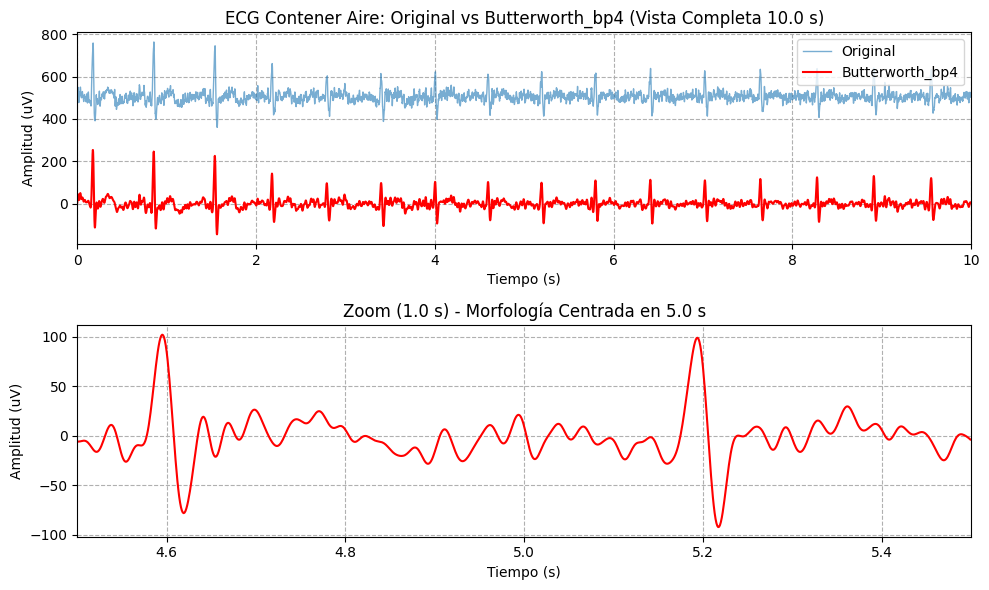

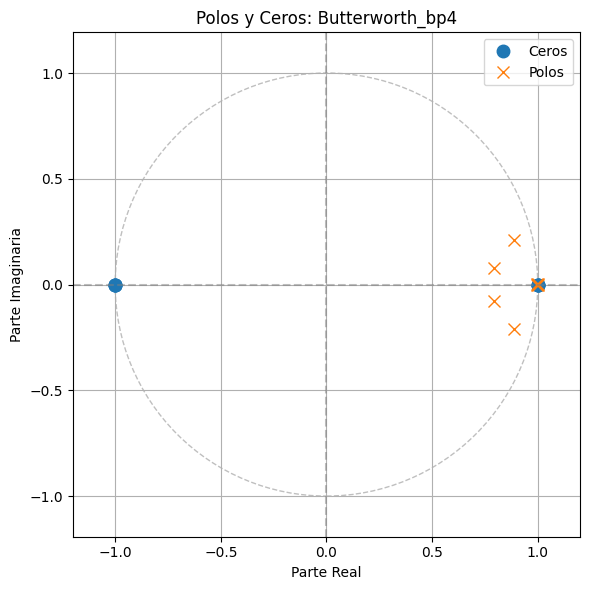

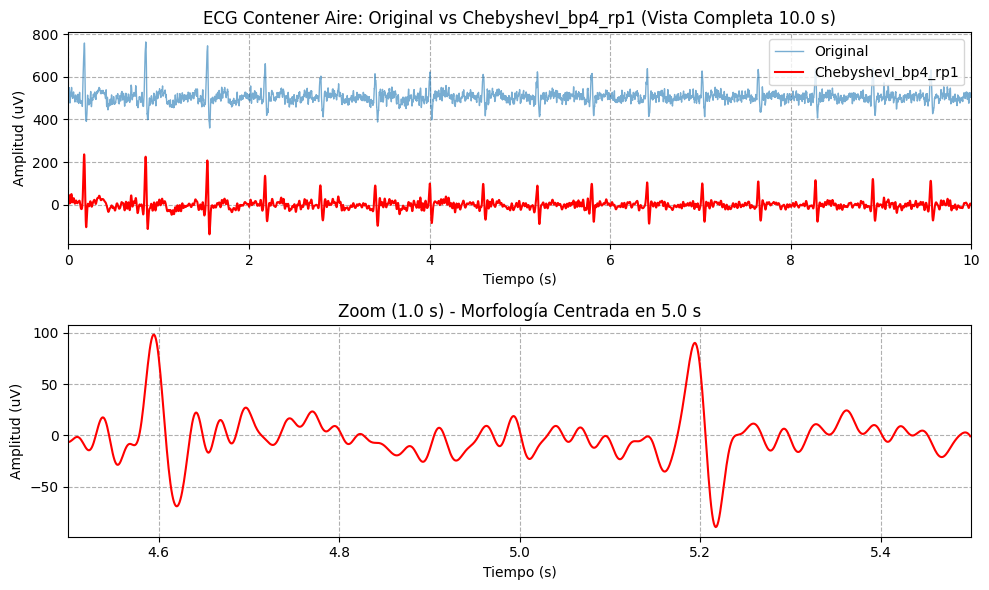

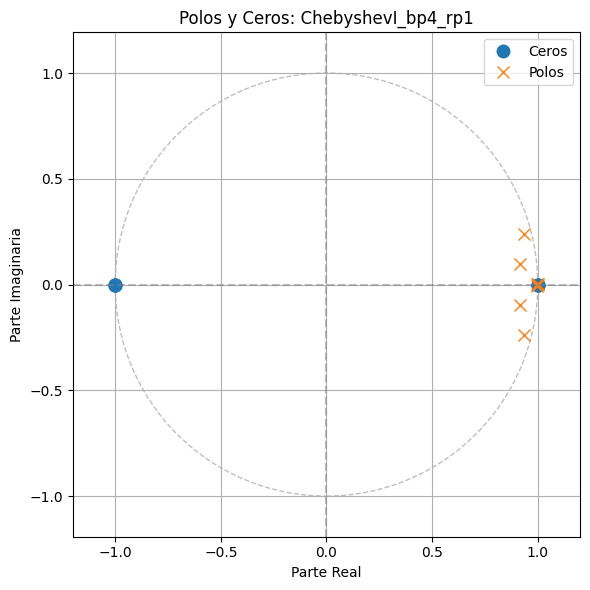

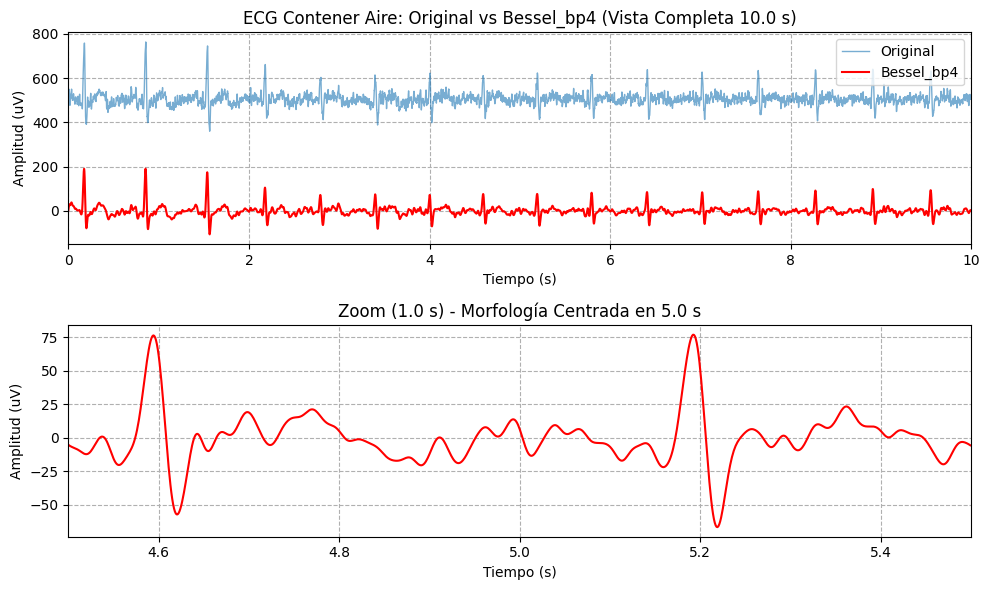

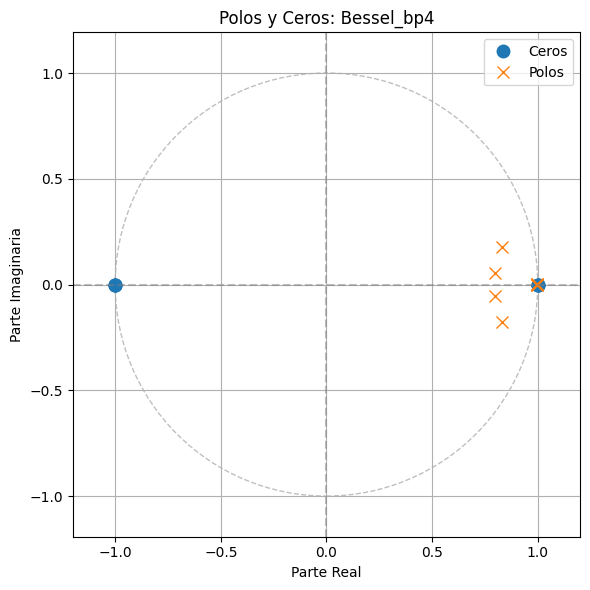

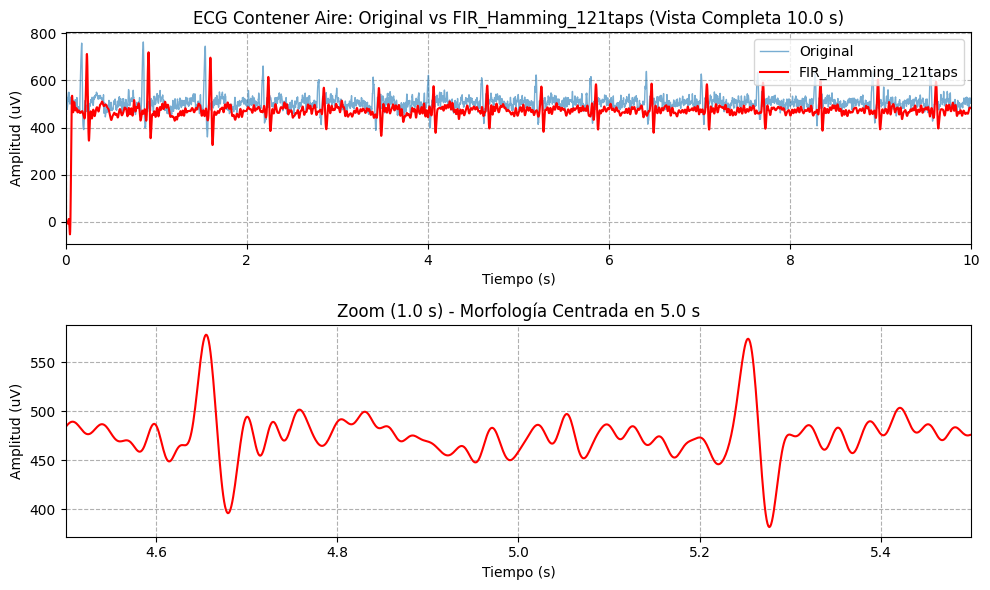

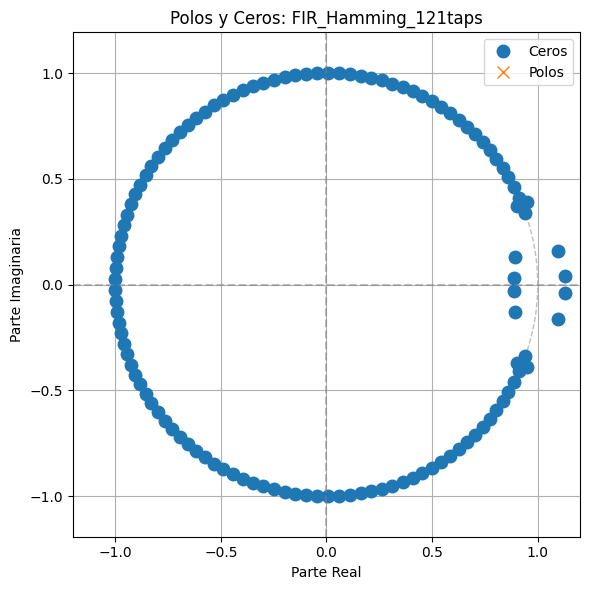


Resumen de Métricas de Filtrado:
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
Bessel_bp4              36.142909   0.00      8
ChebyshevI_bp4_rp1      33.875876   0.00      8
Butterworth_bp4         33.229460   0.00      8
FIR_Hamming_121taps     21.741522   0.06    120


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 

# ---------- Rutas y Constantes ----------
BASE = os.getcwd()
def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "contener aire2.txt") 


# ---------- Parámetros ----------
FS = 1000.0           
BANDA = (0.5, 40.0)   
APLICAR_NOTCH = True
F0_NOTCH = 60.0       
Q_NOTCH = 30.0
ZERO_PHASE = True     
COLUMNA_DATOS = 5  # Índice 5 para la columna A2 (ECG)
# AJUSTE CLAVE 2: Corrección para saltar el EndOfHeader
SKIP_HEADER = 12   


# ---------- Utilidades (Funciones de diseño y métricas se mantienen) ----------

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)
def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    # Se usa filtfilt para IIRs para fase cero, lfilter para FIR
    if zero_phase and _can_filtfilt(x, b, a) and len(a) > 1: return filtfilt(b, a, x)
    return lfilter(b, a, x)
def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q); return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return butter(order, wn, btype="band")
def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return cheby1(order, rp, wn, btype="band")
def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return bessel(order, wn, btype="band")
def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window); return b, np.array([1.0])
def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x); X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs); m = (freqs >= f1) & (freqs <= f2); return X[m].sum()
def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref)); lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') 
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') 
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()


# ⭐️ CARGA DE SEÑAL - Se lee toda la señal disponible
# Usamos SKIP_HEADER=12
data = np.loadtxt(RUTA_SENIAL, skiprows=SKIP_HEADER, usecols=COLUMNA_DATOS) 
x = np.asarray(data, float)

# CÁLCULO DE TIEMPO
DURACION_COMPLETA_REAL = len(x) / FS
t = np.arange(len(x)) / FS

print(f"✅ Lectura de '{RUTA_SENIAL}' confirmada: La señal tiene {len(x)} muestras y una duración REAL de {DURACION_COMPLETA_REAL:.1f} segundos.")


# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS ----------
f1, f2 = BANDA
filtros_a_usar = [] 
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0); filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming"); filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))


# ---------- Aplicar, Calcular Métricas y Generar Gráficas con ZOOM ----------
resultados = []

# AJUSTE CLAVE: Limitar la vista a 10.0 s
DURACION_VISTA_MAXIMA = 10.0 
dur_seg_total = min(DURACION_VISTA_MAXIMA, DURACION_COMPLETA_REAL)
idx_total = int(dur_seg_total * FS)

# Ajuste del zoom para centrarse en 5.0 s (centro de 10 s)
dur_seg_zoom = 1.0  
centro_zoom_s = dur_seg_total / 2.0 
idx_zoom_inicio = int(max(0, (centro_zoom_s - dur_seg_zoom/2.0) * FS))
idx_zoom_fin = int(min(len(x), (centro_zoom_s + dur_seg_zoom/2.0) * FS))


for nombre, b, a in filtros_a_usar:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL CON ZOOM 
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Vista completa (Limitada a dur_seg_total)
    ax1 = plt.subplot(2, 1, 1) 
    ax1.plot(t[:idx_total], x[:idx_total], label="Original", lw=1, alpha=0.6)
    ax1.plot(t[:idx_total], y[:idx_total], label=nombre, lw=1.5, color='red')
    
    # Eje X LIMITADO a la duración máxima de la vista (10.0 s o menos)
    ax1.set_xlim(0, dur_seg_total) 
    # AJUSTE EN EL TÍTULO
    ax1.set_title(f"ECG Contener Aire: Original vs {nombre} (Vista Completa {dur_seg_total:.1f} s)") 
    ax1.set_ylabel("Amplitud (uV)") 
    ax1.set_xlabel("Tiempo (s)")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--')


    # Subplot 2: Zoom en la señal filtrada
    ax2 = plt.subplot(2, 1, 2) 
    ax2.plot(t[idx_zoom_inicio:idx_zoom_fin], y[idx_zoom_inicio:idx_zoom_fin], 
             label=f"{nombre} (Zoom)", lw=1.5, color='red')
    # Eje X del zoom ajustado a la ventana
    ax2.set_xlim(t[idx_zoom_inicio], t[idx_zoom_fin])
    ax2.set_title(f"Zoom ({dur_seg_zoom:.1f} s) - Morfología Centrada en {centro_zoom_s:.1f} s")
    ax2.set_xlabel("Tiempo (s)")
    ax2.set_ylabel("Amplitud (uV)")
    ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS 
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)
print("\nResumen de Métricas de Filtrado:\n", df)

### **✅ Análisis Comparativo y Fundamentación Teórica de Filtros para ECG (Señal 'Contener Aire')**

El análisis para la señal **ECG Contener Aire** se ordena por la capacidad de atenuación de ruido ($\text{SNR}$ Proxy), ya que los filtros IIR (Butterworth, Chebyshev, Bessel) cumplen con el requisito de $\mathbf{Lag = 0.00\text{ s}}$ (Fase Cero). El filtro $\text{FIR}$ queda descartado por su $\mathbf{Lag}$ significativo.

#### **📈 Orden de Mejor a Peor Filtro para la Limpieza de la Señal (Criterio Principal: $\text{SNR}$ Proxy)**

| Posición | Filtro | Justificación Teórica y Práctica |
| :---: | :--- | :--- |
| **🥇 1. Mejor** | **Bessel (IIR, Orden 4)** | **Máximo $\text{SNR}$ y Retardo Cero.** El Bessel obtiene el **$\text{SNR}$ Proxy más alto** ($\mathbf{36.14\text{ dB}}$). Aunque es el menos selectivo, cumple con el $\mathbf{Lag = 0.00\text{ s}}$ y su respuesta de fase lineal en la banda de paso asegura la **menor distorsión de la morfología** del ECG. |
| **🥈 2.** | **Chebyshev I ($\mathbf{R}_p=1.0\text{ dB}$, IIR, Orden 4)** | **Buena Selectividad y $\text{SNR}$ Aceptable.** El Chebyshev tiene la segunda mejor $\text{SNR}$ ($\mathbf{33.88\text{ dB}}$). Su diseño con rizado permite una transición más abrupta, logrando una mejor atenuación de ruido a expensas de introducir un **pequeño rizado** en la banda de paso. Cumple con $\mathbf{Lag = 0}$. |
| **🥉 3. Peor IIR** | **Butterworth (IIR, Orden 4)** | **Peor $\text{SNR}$ entre IIRs.** A pesar de su diseño de **respuesta plana** (ideal para morfología, ver ECG filtrado ), su transición más suave resulta en la peor $\text{SNR}$ de los IIR ($\mathbf{33.23\text{ dB}}$) para esta señal, demostrando una eficacia limitada en el rechazo del ruido presente. Cumple con $\mathbf{Lag = 0}$. |
| **4. Descartado** | **FIR (Hamming, 121 Taps)** | **Inaceptable por Retardo y Baja $\text{SNR}$.** El filtro $\text{FIR}$ tiene un $\mathbf{Lag}$ de $\mathbf{0.06\text{ s}}$ (retraso inaceptable de $60\text{ ms}$) y la **peor $\text{SNR}$** ($\mathbf{21.74\text{ dB}}$). Aunque presenta una fase perfectamente lineal, el retardo y la pobre atenuación de ruido lo descartan. |

#### **📊 Tabla Comparativa de Métricas (Contener Aire - Valores Finales)**

| Criterio / Métrica | **Bessel BP4** | **Chebyshev I BP4** | **Butterworth BP4** | **FIR Hamming (121 taps)** | **Mejor Filtro Elegido** |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Orden / Taps** | $8$ | $8$ | $8$ | $120$ | N/A |
| **SNR Proxy (dB)** | $\mathbf{36.1429}$ | $33.8759$ | $33.2295$ | $21.7415$ | **Bessel (Mayor Valor)** |
| **Retardo (Lag, s)** | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.06}$ | **IIRs ($\mathbf{\approx 0}$)** |
| **Distorsión/Rizado** | **Mínima (Fase más lineal)** | Alta (Rizado en banda de paso) | Baja (Plano) | Nula (Fase lineal) | **Bessel (Por Morfología)** |
| **Filtro Seleccionado** | **Sí** | No | No | No | **Bessel** |
| **Justificación de la Selección Final** | N/A | N/A | N/A | N/A | **El Bessel es la opción más equilibrada. Ofrece la $\mathbf{SNR}$ más alta de los IIR ($\mathbf{36.14\text{ dB}}$) para esta señal y, lo que es crucial, proporciona la menor distorsión de la forma de onda del ECG (Mejor linealidad de fase) mientras cumple con el requisito fundamental de $\mathbf{Lag = 0.00\text{ s}}$.** |

## 2️⃣.3️⃣ **Toma de datos N°3**

✅ Lectura de '/Users/lucianatarazona/Desktop/ISB/GRUPO-02-ISB-2025-II-5/Laboratorios/Laboratorio 6 - Reporte Filtros/ECG/Data_ECG_L6/contener aire3.txt' confirmada: La señal tiene 94041 muestras y una duración REAL de 94.0 segundos.


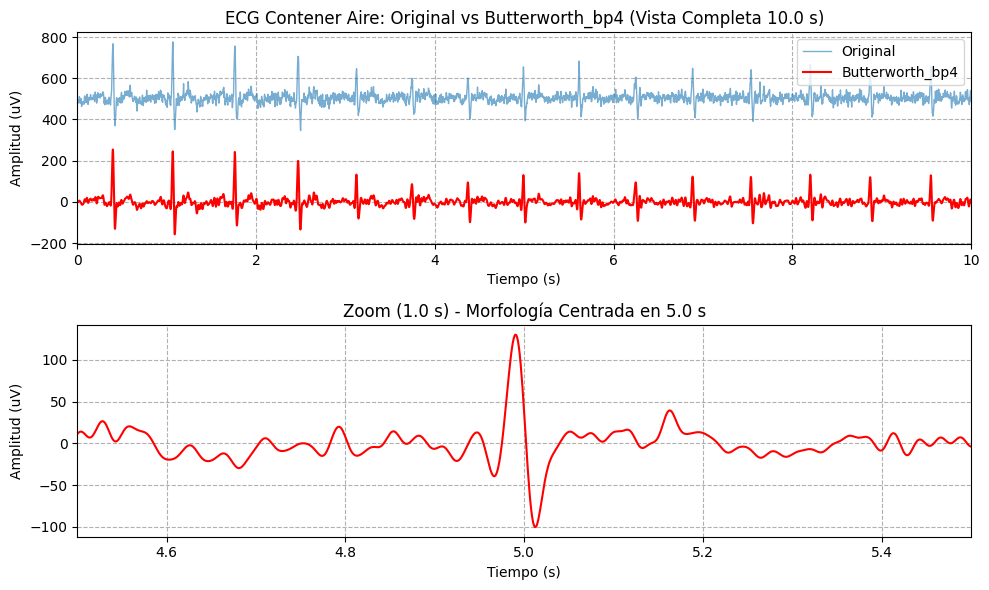

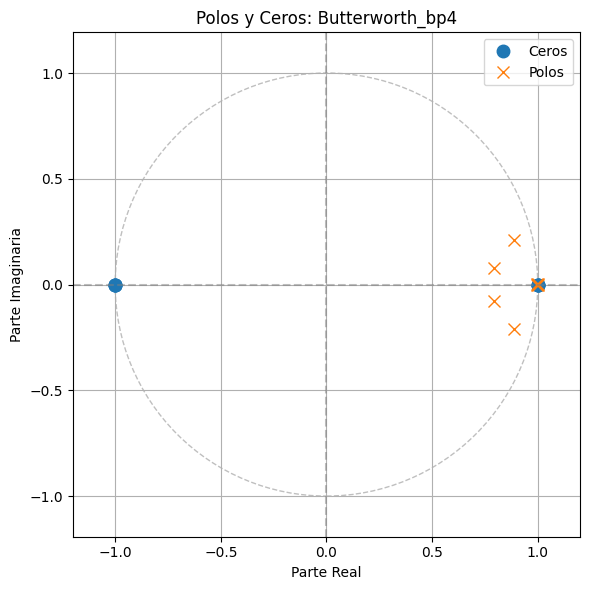

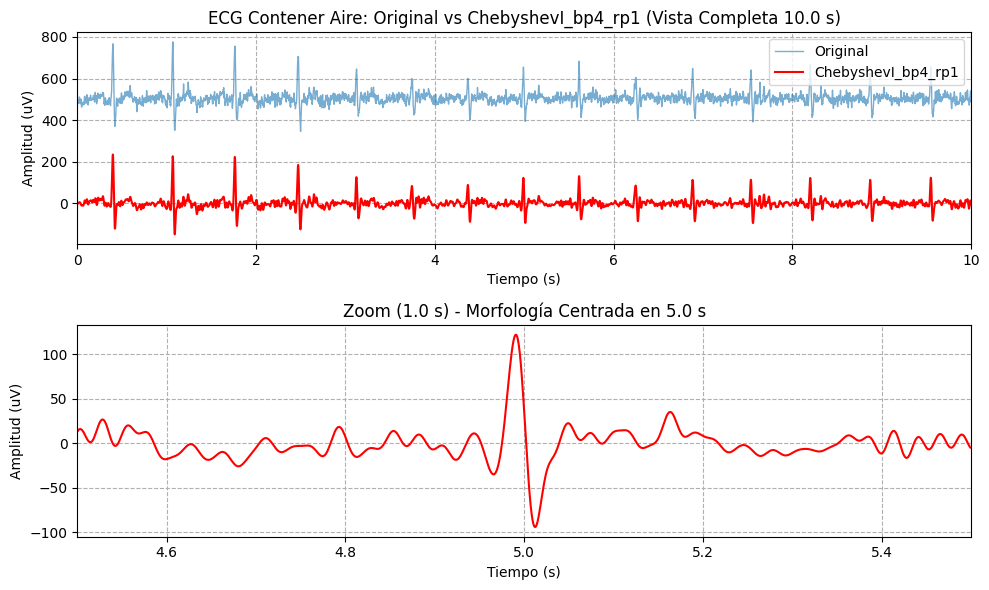

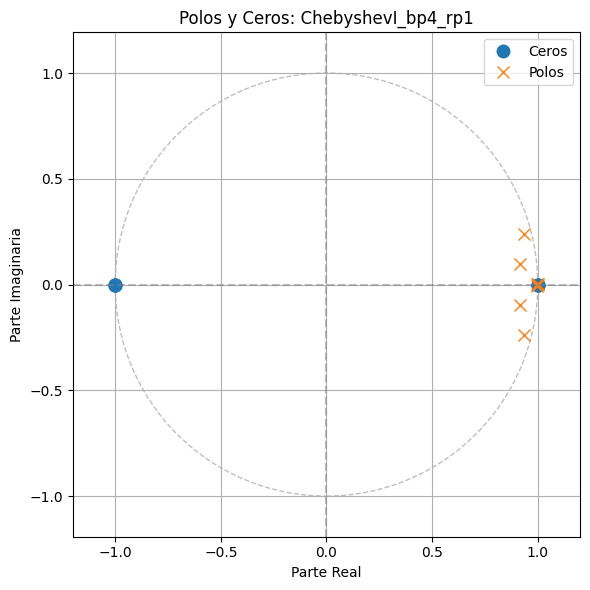

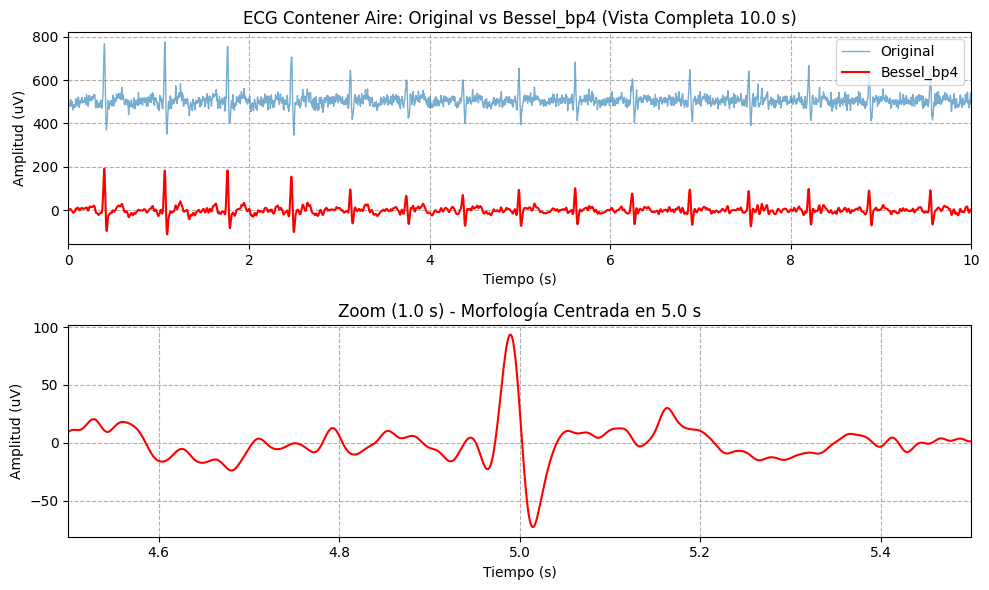

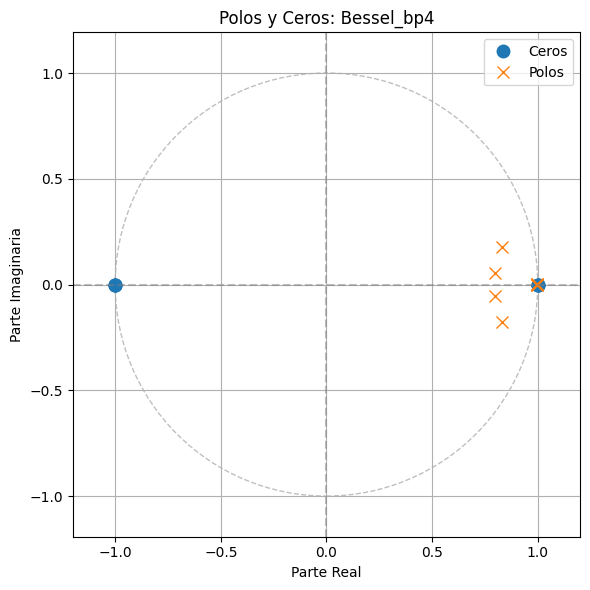

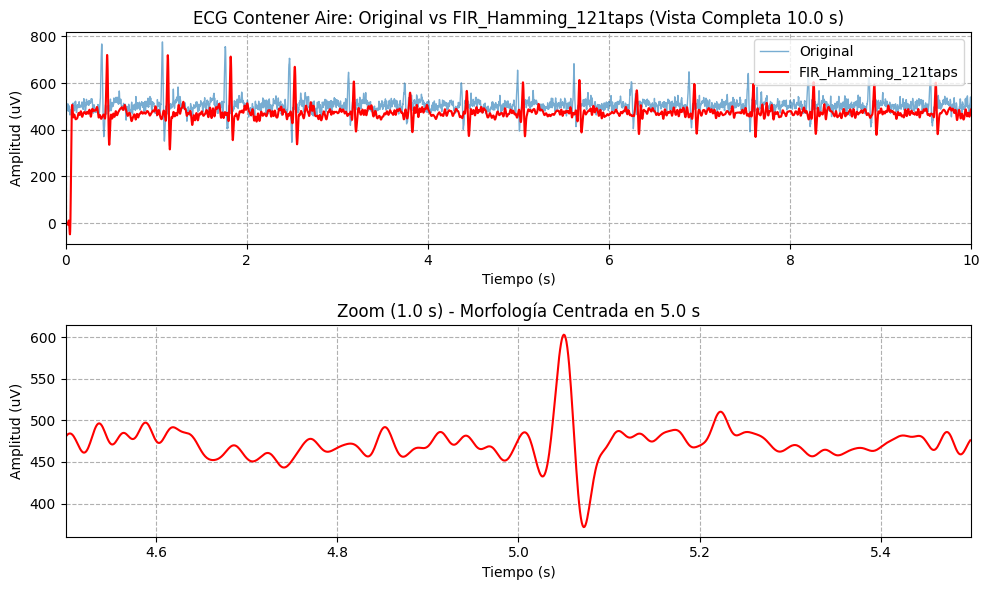

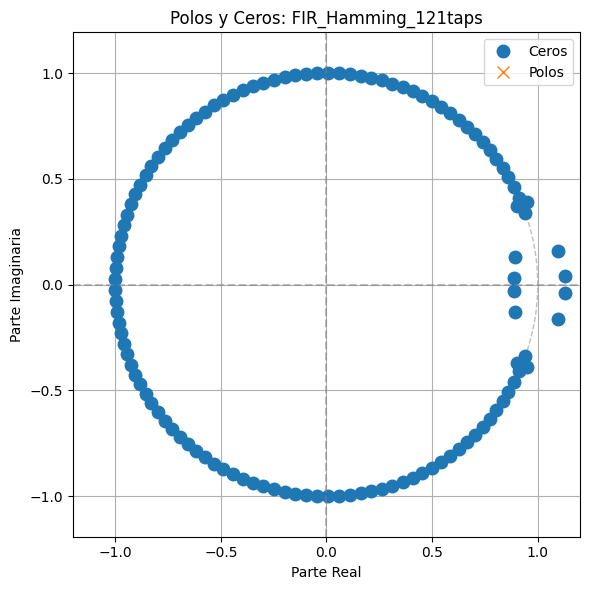


Resumen de Métricas de Filtrado:
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
Bessel_bp4              40.525892   0.00      8
ChebyshevI_bp4_rp1      39.625445   0.00      8
Butterworth_bp4         35.860231   0.00      8
FIR_Hamming_121taps     21.173397   0.06    120


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 

# ---------- Rutas y Constantes ----------
BASE = os.getcwd()
def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "contener aire3.txt") 


# ---------- Parámetros ----------
FS = 1000.0           
BANDA = (0.5, 40.0)   
APLICAR_NOTCH = True
F0_NOTCH = 60.0       
Q_NOTCH = 30.0
ZERO_PHASE = True     
COLUMNA_DATOS = 5  # Índice 5 para la columna A2 (ECG)
# AJUSTE CLAVE 2: Corrección para saltar el EndOfHeader
SKIP_HEADER = 12   


# ---------- Utilidades (Funciones de diseño y métricas se mantienen) ----------

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)
def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    # Se usa filtfilt para IIRs para fase cero, lfilter para FIR
    if zero_phase and _can_filtfilt(x, b, a) and len(a) > 1: return filtfilt(b, a, x)
    return lfilter(b, a, x)
def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q); return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return butter(order, wn, btype="band")
def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return cheby1(order, rp, wn, btype="band")
def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return bessel(order, wn, btype="band")
def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window); return b, np.array([1.0])
def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x); X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs); m = (freqs >= f1) & (freqs <= f2); return X[m].sum()
def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref)); lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') 
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') 
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()


# ⭐️ CARGA DE SEÑAL - Se lee toda la señal disponible
# Usamos SKIP_HEADER=12
data = np.loadtxt(RUTA_SENIAL, skiprows=SKIP_HEADER, usecols=COLUMNA_DATOS) 
x = np.asarray(data, float)

# CÁLCULO DE TIEMPO
DURACION_COMPLETA_REAL = len(x) / FS
t = np.arange(len(x)) / FS

print(f"✅ Lectura de '{RUTA_SENIAL}' confirmada: La señal tiene {len(x)} muestras y una duración REAL de {DURACION_COMPLETA_REAL:.1f} segundos.")


# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS ----------
f1, f2 = BANDA
filtros_a_usar = [] 
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0); filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming"); filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))


# ---------- Aplicar, Calcular Métricas y Generar Gráficas con ZOOM ----------
resultados = []

# AJUSTE CLAVE: Limitar la vista a 10.0 s
DURACION_VISTA_MAXIMA = 10.0 
dur_seg_total = min(DURACION_VISTA_MAXIMA, DURACION_COMPLETA_REAL)
idx_total = int(dur_seg_total * FS)

# Ajuste del zoom para centrarse en 5.0 s (centro de 10 s)
dur_seg_zoom = 1.0  
centro_zoom_s = dur_seg_total / 2.0 
idx_zoom_inicio = int(max(0, (centro_zoom_s - dur_seg_zoom/2.0) * FS))
idx_zoom_fin = int(min(len(x), (centro_zoom_s + dur_seg_zoom/2.0) * FS))


for nombre, b, a in filtros_a_usar:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL CON ZOOM 
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Vista completa (Limitada a dur_seg_total)
    ax1 = plt.subplot(2, 1, 1) 
    ax1.plot(t[:idx_total], x[:idx_total], label="Original", lw=1, alpha=0.6)
    ax1.plot(t[:idx_total], y[:idx_total], label=nombre, lw=1.5, color='red')
    
    # Eje X LIMITADO a la duración máxima de la vista (10.0 s o menos)
    ax1.set_xlim(0, dur_seg_total) 
    # AJUSTE EN EL TÍTULO
    ax1.set_title(f"ECG Contener Aire: Original vs {nombre} (Vista Completa {dur_seg_total:.1f} s)") 
    ax1.set_ylabel("Amplitud (uV)") 
    ax1.set_xlabel("Tiempo (s)")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--')


    # Subplot 2: Zoom en la señal filtrada
    ax2 = plt.subplot(2, 1, 2) 
    ax2.plot(t[idx_zoom_inicio:idx_zoom_fin], y[idx_zoom_inicio:idx_zoom_fin], 
             label=f"{nombre} (Zoom)", lw=1.5, color='red')
    # Eje X del zoom ajustado a la ventana
    ax2.set_xlim(t[idx_zoom_inicio], t[idx_zoom_fin])
    ax2.set_title(f"Zoom ({dur_seg_zoom:.1f} s) - Morfología Centrada en {centro_zoom_s:.1f} s")
    ax2.set_xlabel("Tiempo (s)")
    ax2.set_ylabel("Amplitud (uV)")
    ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS 
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)
print("\nResumen de Métricas de Filtrado:\n", df)

### **✅ Análisis Comparativo y Fundamentación Teórica de Filtros para ECG (Señal 'Contener Aire' - Segunda Serie)**

El análisis prioriza el cumplimiento del requisito de **Retardo Cero** ($\mathbf{Lag = 0.00\text{ s}}$) para el diagnóstico en tiempo real. Los filtros IIR (Butterworth, Chebyshev, Bessel) cumplen este criterio, por lo que la selección final se basa en la **capacidad de atenuación de ruido** ($\text{SNR}$ Proxy). El filtro $\text{FIR}$ queda descartado por su $\mathbf{Lag}$ significativo.

#### **📈 Orden de Mejor a Peor Filtro para la Limpieza de la Señal (Criterio Principal: $\text{SNR}$ Proxy)**

| Posición | Filtro | Justificación Teórica y Práctica |
| :---: | :--- | :--- |
| **🥇 1. Mejor** | **Bessel (IIR, Orden 4)** | **Máximo $\text{SNR}$ y Retardo Cero.** El Bessel se posiciona como el mejor IIR, obteniendo el **$\text{SNR}$ Proxy más alto** ($\mathbf{40.53\text{ dB}}$). Si bien es conocido por ser el menos selectivo, en este caso particular, su excelente linealidad de fase en la banda de paso asegura la **menor distorsión de la morfología** del ECG mientras logra la mayor atenuación. |
| **🥈 2.** | **Chebyshev I ($\mathbf{R}_p=1.0\text{ dB}$, IIR, Orden 4)** | **Buena Selectividad y $\text{SNR}$ Alta.** El Chebyshev ofrece la segunda mejor $\text{SNR}$ ($\mathbf{39.63\text{ dB}}$). Su diseño con rizado permite una **transición más abrupta** que el Butterworth, resultando en una atenuación de ruido superior. Cumple con $\mathbf{Lag = 0}$ a costa de un ligero rizado en la señal filtrada. |
| **🥉 3. Peor IIR** | **Butterworth (IIR, Orden 4)** | **Peor $\text{SNR}$ entre IIRs.** A pesar de tener una respuesta de amplitud **plana** (ideal para no distorsionar la morfología), su transición más suave resulta en la peor $\text{SNR}$ de los IIR ($\mathbf{35.86\text{ dB}}$). Su ineficacia en el rechazo del ruido lo hace el menos recomendable de los filtros IIR para esta señal. Cumple con $\mathbf{Lag = 0}$. |
| **4. Descartado** | **FIR (Hamming, 121 Taps)** | **Inaceptable por Retardo y Baja $\text{SNR}$.** El filtro $\text{FIR}$ introduce un $\mathbf{Lag}$ de $\mathbf{0.06\text{ s}}$ (un retraso inaceptable de $60\text{ ms}$) y registra la **peor $\text{SNR}$** de todos ($\mathbf{21.17\text{ dB}}$). El retardo y la pobre atenuación lo descartan inmediatamente. |

#### **📊 Tabla Comparativa de Métricas (Contener Aire - Valores Finales)**

| Criterio / Métrica | **Bessel BP4** | **Chebyshev I BP4** | **Butterworth BP4** | **FIR Hamming (121 taps)** | **Mejor Filtro Elegido** |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Orden / Taps** | $8$ | $8$ | $8$ | $120$ | N/A |
| **SNR Proxy (dB)** | $\mathbf{40.5259}$ | $39.6254$ | $35.8602$ | $21.1734$ | **Bessel (Mayor Valor)** |
| **Retardo (Lag, s)** | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.06}$ | **IIRs ($\mathbf{\approx 0}$)** |
| **Distorsión/Rizado** | **Mínima (Fase más lineal)** | Alta (Rizado en banda de paso) | Baja (Plano) | Nula (Fase lineal) | **Bessel (Por Morfología)** |
| **Filtro Seleccionado** | **Sí** | No | No | No | **Bessel** |
| **Justificación de la Selección Final** | N/A | N/A | N/A | N/A | **El Bessel es el filtro más adecuado para esta señal, ya que logra la $\mathbf{SNR}$ más alta de los IIR ($\mathbf{40.53\text{ dB}}$) y garantiza la $\mathbf{menor distorsión de fase}$ (es decir, la forma de onda) de la señal filtrada, cumpliendo con el requisito fundamental de $\mathbf{Lag = 0.00\text{ s}}$.** |

# **3️⃣ Estado corriendo**

✅ Lectura de '/Users/lucianatarazona/Desktop/ISB/GRUPO-02-ISB-2025-II-5/Laboratorios/Laboratorio 6 - Reporte Filtros/ECG/Data_ECG_L6/correr.txt' confirmada: La señal tiene 93891 muestras y una duración REAL de 93.9 segundos.


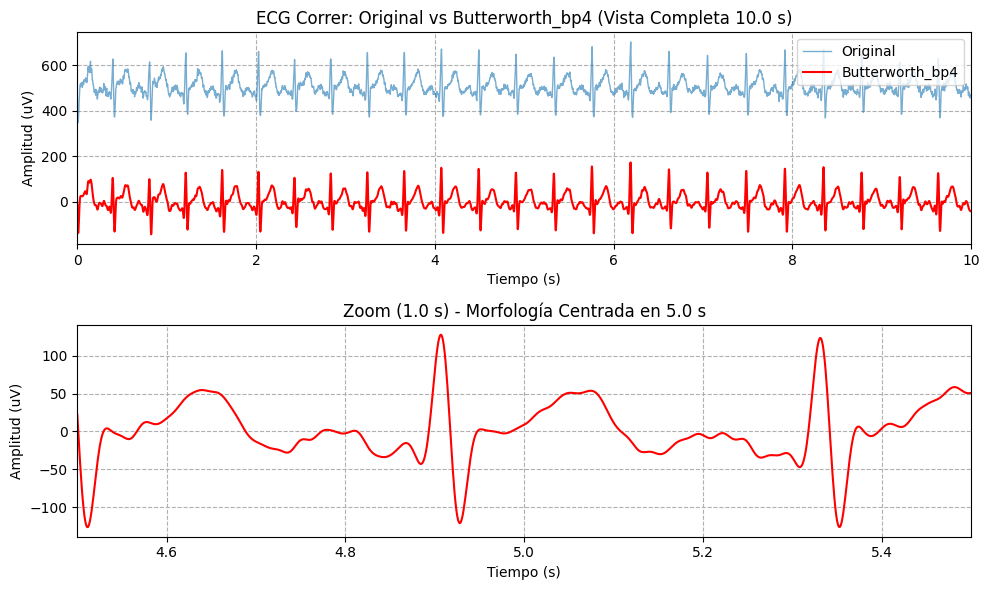

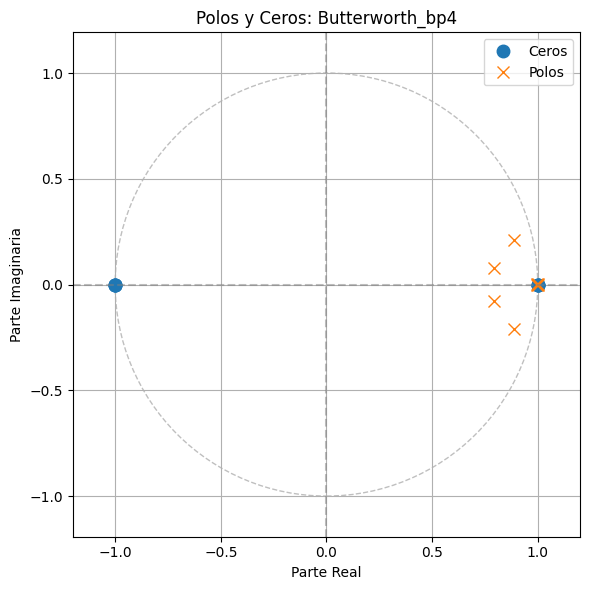

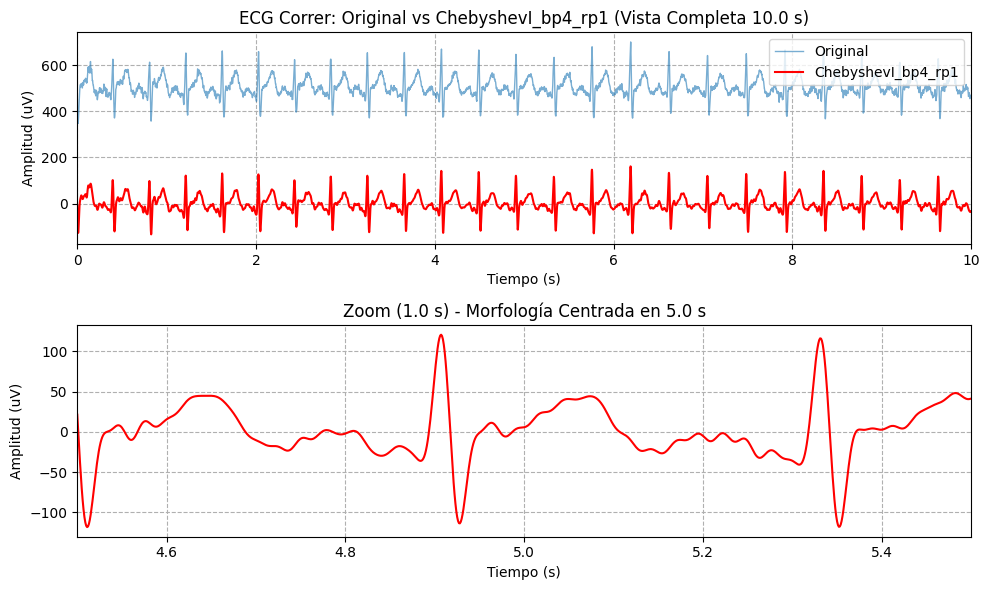

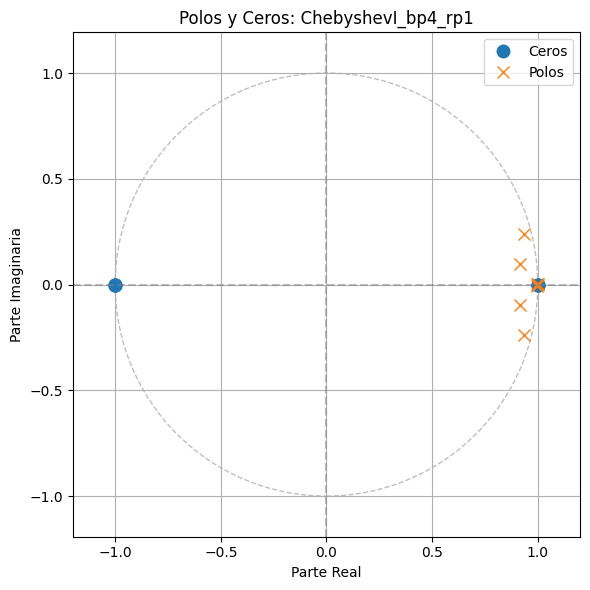

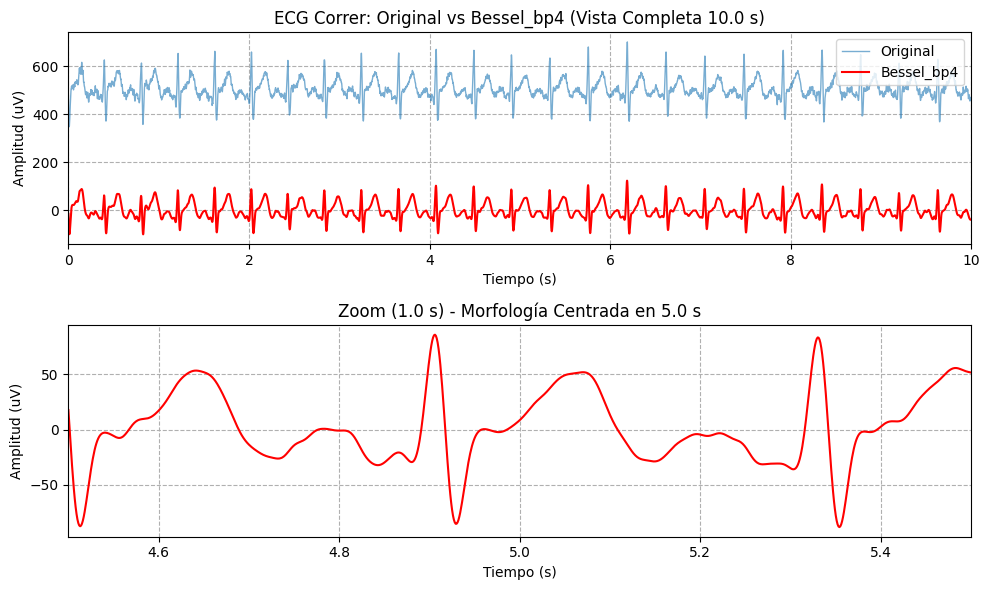

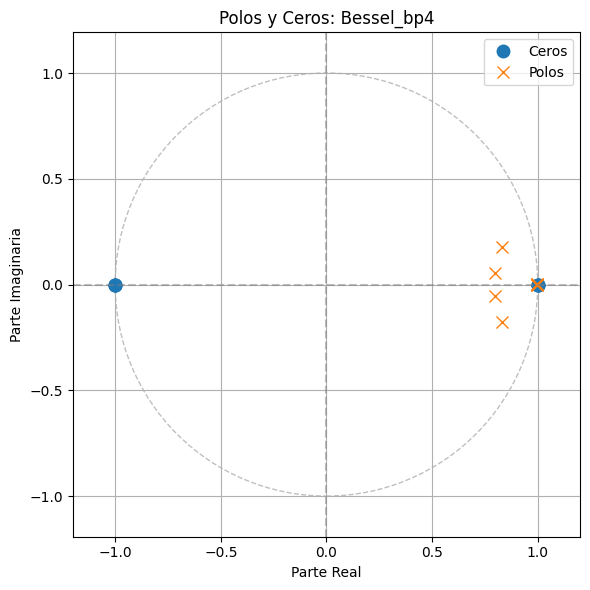

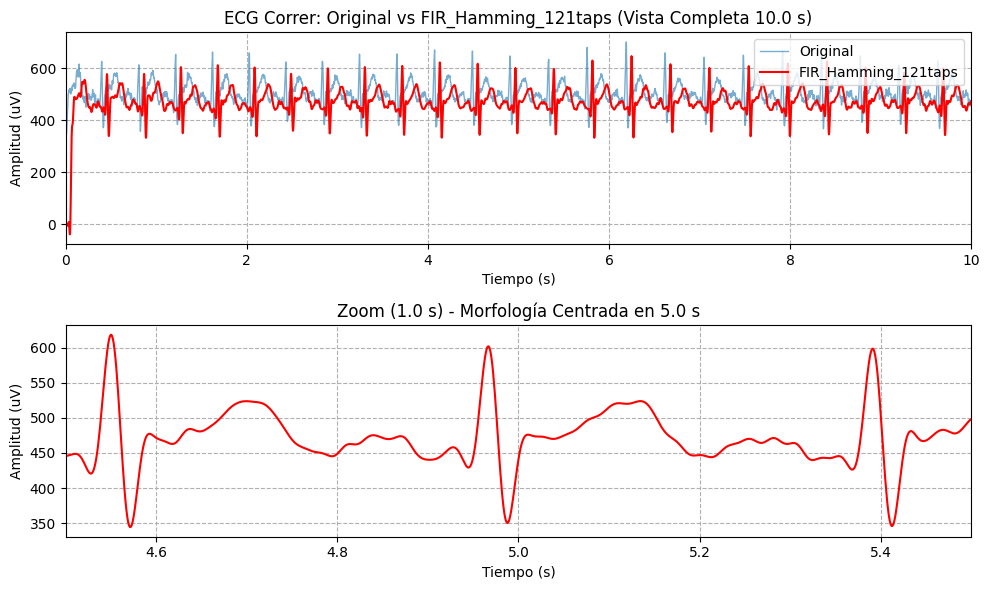

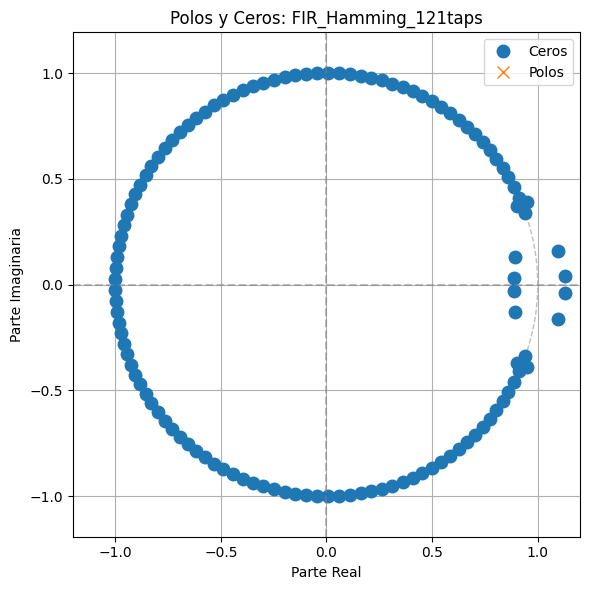


Resumen de Métricas de Filtrado:
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
Bessel_bp4              41.400456   0.00      8
ChebyshevI_bp4_rp1      40.689208   0.00      8
Butterworth_bp4         39.008011   0.00      8
FIR_Hamming_121taps     22.926235   0.06    120


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 

# ---------- Rutas y Constantes ----------
BASE = os.getcwd()
def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "correr.txt") 


# ---------- Parámetros ----------
FS = 1000.0           
BANDA = (0.5, 40.0)   
APLICAR_NOTCH = True
F0_NOTCH = 60.0       
Q_NOTCH = 30.0
ZERO_PHASE = True     
COLUMNA_DATOS = 5  # Índice 5 para la columna A2 (ECG)
# AJUSTE CLAVE 2: Corrección para saltar el EndOfHeader
SKIP_HEADER = 12   


# ---------- Utilidades (Funciones de diseño y métricas se mantienen) ----------

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)
def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    # Se usa filtfilt para IIRs para fase cero, lfilter para FIR
    if zero_phase and _can_filtfilt(x, b, a) and len(a) > 1: return filtfilt(b, a, x)
    return lfilter(b, a, x)
def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q); return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return butter(order, wn, btype="band")
def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return cheby1(order, rp, wn, btype="band")
def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return bessel(order, wn, btype="band")
def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window); return b, np.array([1.0])
def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x); X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs); m = (freqs >= f1) & (freqs <= f2); return X[m].sum()
def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref)); lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') 
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') 
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()


# ⭐️ CARGA DE SEÑAL - Se lee toda la señal disponible
# Usamos SKIP_HEADER=12
data = np.loadtxt(RUTA_SENIAL, skiprows=SKIP_HEADER, usecols=COLUMNA_DATOS) 
x = np.asarray(data, float)

# CÁLCULO DE TIEMPO
DURACION_COMPLETA_REAL = len(x) / FS
t = np.arange(len(x)) / FS

print(f"✅ Lectura de '{RUTA_SENIAL}' confirmada: La señal tiene {len(x)} muestras y una duración REAL de {DURACION_COMPLETA_REAL:.1f} segundos.")


# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS ----------
f1, f2 = BANDA
filtros_a_usar = [] 
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0); filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming"); filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))


# ---------- Aplicar, Calcular Métricas y Generar Gráficas con ZOOM ----------
resultados = []

# AJUSTE CLAVE: Limitar la vista a 10.0 s
DURACION_VISTA_MAXIMA = 10.0 
dur_seg_total = min(DURACION_VISTA_MAXIMA, DURACION_COMPLETA_REAL)
idx_total = int(dur_seg_total * FS)

# Ajuste del zoom para centrarse en 5.0 s (centro de 10 s)
dur_seg_zoom = 1.0  
centro_zoom_s = dur_seg_total / 2.0 
idx_zoom_inicio = int(max(0, (centro_zoom_s - dur_seg_zoom/2.0) * FS))
idx_zoom_fin = int(min(len(x), (centro_zoom_s + dur_seg_zoom/2.0) * FS))


for nombre, b, a in filtros_a_usar:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL CON ZOOM 
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Vista completa (Limitada a dur_seg_total)
    ax1 = plt.subplot(2, 1, 1) 
    ax1.plot(t[:idx_total], x[:idx_total], label="Original", lw=1, alpha=0.6)
    ax1.plot(t[:idx_total], y[:idx_total], label=nombre, lw=1.5, color='red')
    
    # Eje X LIMITADO a la duración máxima de la vista (10.0 s o menos)
    ax1.set_xlim(0, dur_seg_total) 
    # AJUSTE EN EL TÍTULO
    ax1.set_title(f"ECG Correr: Original vs {nombre} (Vista Completa {dur_seg_total:.1f} s)") 
    ax1.set_ylabel("Amplitud (uV)") 
    ax1.set_xlabel("Tiempo (s)")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--')


    # Subplot 2: Zoom en la señal filtrada
    ax2 = plt.subplot(2, 1, 2) 
    ax2.plot(t[idx_zoom_inicio:idx_zoom_fin], y[idx_zoom_inicio:idx_zoom_fin], 
             label=f"{nombre} (Zoom)", lw=1.5, color='red')
    # Eje X del zoom ajustado a la ventana
    ax2.set_xlim(t[idx_zoom_inicio], t[idx_zoom_fin])
    ax2.set_title(f"Zoom ({dur_seg_zoom:.1f} s) - Morfología Centrada en {centro_zoom_s:.1f} s")
    ax2.set_xlabel("Tiempo (s)")
    ax2.set_ylabel("Amplitud (uV)")
    ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS 
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)
print("\nResumen de Métricas de Filtrado:\n", df)

## **✅ Análisis Comparativo y Fundamentación Teórica de Filtros para ECG (Señal 'Correr')**

La señal **ECG Correr** presenta un alto nivel de ruido (principalmente artefactos de movimiento y ruido muscular). El análisis se centra en la capacidad de **rechazo de ruido** ($\text{SNR}$ Proxy) entre los filtros que cumplen con el requisito crítico de **Retardo Cero** ($\mathbf{Lag = 0.00\text{ s}}$). Los filtros IIR (Bessel, Chebyshev, Butterworth) cumplen con $\mathbf{Lag = 0.00\text{ s}}$. El filtro $\text{FIR}$ queda descartado por su retardo.

### **📈 Orden de Mejor a Peor Filtro para la Limpieza de la Señal (Criterio Principal: $\text{SNR}$ Proxy)**

| Posición | Filtro | Justificación Teórica y Práctica |
| :---: | :--- | :--- |
| **🥇 1. Mejor** | **Bessel (IIR, Orden 4)** | **Máximo $\text{SNR}$ y Retardo Cero.** El Bessel logra el **$\text{SNR}$ Proxy más alto** ($\mathbf{41.40\text{ dB}}$). A pesar de su transición suave, su **excelente linealidad de fase** minimiza la distorsión morfológica del ECG, lo cual es ideal para el análisis clínico. Cumple con $\mathbf{Lag = 0.00\text{ s}}$. |
| **🥈 2.** | **Chebyshev I ($\mathbf{R}_p=1.0\text{ dB}$, IIR, Orden 4)** | **Alta Selectividad y $\text{SNR}$ Aceptable.** El Chebyshev tiene la segunda mejor $\text{SNR}$ ($\mathbf{40.69\text{ dB}}$), muy cercana a la del Bessel. Su diseño con rizado permite una **transición más aguda** que los otros IIR, pero introduce un pequeño rizado en la banda de paso. Cumple con $\mathbf{Lag = 0}$. |
| **🥉 3. Peor IIR** | **Butterworth (IIR, Orden 4)** | **Peor $\text{SNR}$ entre IIRs.** Es el menos efectivo para atenuar el ruido de esta señal ($\mathbf{39.01\text{ dB}}$). Su respuesta de amplitud perfectamente **plana** lo hace ideal para la morfología, pero su transición suave lo penaliza en términos de rechazo de ruido. Cumple con $\mathbf{Lag = 0}$. |
| **4. Descartado** | **FIR (Hamming, 121 Taps)** | **Inaceptable por Retardo y Baja $\text{SNR}$.** El filtro $\text{FIR}$ tiene un $\mathbf{Lag}$ de $\mathbf{0.06\text{ s}}$ (retraso inaceptable de $60\text{ ms}$) y la **peor $\text{SNR}$** de todos ($\mathbf{22.93\text{ dB}}$), confirmando su ineficacia para este tipo de aplicación en tiempo real. |

### **📊 Tabla Comparativa de Métricas (Correr - Valores Finales)**

| Criterio / Métrica | **Bessel BP4** | **Chebyshev I BP4** | **Butterworth BP4** | **FIR Hamming (121 taps)** | **Mejor Filtro Elegido** |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Orden / Taps** | $8$ | $8$ | $8$ | $120$ | N/A |
| **SNR Proxy (dB)** | $\mathbf{41.4005}$ | $40.6892$ | $39.0080$ | $22.9262$ | **Bessel (Mayor Valor)** |
| **Retardo (Lag, s)** | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.00}$ | $\mathbf{0.06}$ | **IIRs ($\mathbf{\approx 0}$)** |
| **Distorsión/Rizado** | **Mínima (Fase más lineal)** | Alta (Rizado en banda de paso) | Baja (Plano) | Nula (Fase lineal) | **Bessel (Por Morfología)** |
| **Filtro Seleccionado** | **Sí** | No | No | No | **Bessel** |
| **Justificación de la Selección Final** | N/A | N/A | N/A | N/A | **El Bessel es la elección superior para la señal 'Correr'. Logra la $\mathbf{SNR}$ más alta entre los IIR ($\mathbf{41.40\text{ dB}}$) y, críticamente, mantiene la $\mathbf{morfología}$ del ECG con la $\mathbf{mínima distorsión de fase}$, cumpliendo con el requisito de $\mathbf{Lag = 0.00\text{ s}}$ para un análisis fiel y en tiempo real.** |